In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [208]:
df = pd.read_csv(r"C:\Users\cks12\Downloads\PML Project\dataset\raw\CleanDataset.csv")
df.corr()['Attrition'].sort_values()

WorkExperience                     -0.216722
MonthlyIncome                      -0.202379
CurrentProfile                     -0.198538
Age                                -0.180490
MaritalStatus_Married              -0.165064
Designation_Manager                -0.141719
Designation_AVP                    -0.115766
Department_Analytics               -0.114451
Designation_VP                     -0.072545
EducationField_CA                  -0.052707
TravelProfile_Rarely               -0.051362
Gender_F                           -0.048519
EducationField_Statistics          -0.048031
LastPromotion                      -0.038565
Designation_Senior Manager         -0.032605
Unnamed: 0                         -0.023067
EmployeeID                         -0.023067
SalaryHikelastYear                 -0.006778
Department_Marketing                0.010778
ESOPs                               0.012200
WorkLifeBalance                     0.013608
HourlnWeek                          0.021145
EducationF

In [230]:
X=df.drop(columns=['Unnamed: 0','EmployeeID','Attrition','Department_Sales','HomeToWork','NumCompaniesWorked','Department_Sales','EducationField_Marketing Diploma','Gender_M','EducationField_MBA','HourlnWeek','Designation_VP','EducationField_CA','WorkLifeBalance','TravelProfile_Rarely','Gender_F','EducationField_Statistics','LastPromotion','ESOPs','Designation_Senior Manager','SalaryHikelastYear','Department_Marketing'],axis=1)

In [231]:
y=df['Attrition']

In [232]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [233]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [234]:
Xtrain_scaled

array([[-0.89390912,  2.02989836,  0.64110978, ..., -0.72231512,
        -0.92338867,  1.36954287],
       [-0.00335248, -2.58054019,  1.38239295, ...,  1.38443731,
        -0.92338867, -0.73017065],
       [ 1.44380206,  0.87728872, -0.1001734 , ..., -0.72231512,
        -0.92338867, -0.73017065],
       ...,
       [ 1.66644122,  0.87728872, -0.1001734 , ...,  1.38443731,
        -0.92338867, -0.73017065],
       [-0.67126996,  0.87728872, -1.58273976, ..., -0.72231512,
        -0.92338867,  1.36954287],
       [-0.89390912, -0.27532091, -0.1001734 , ..., -0.72231512,
        -0.92338867,  1.36954287]])

In [235]:
prior_mean = np.zeros(Xtrain_scaled.shape[1]) #p_m

In [236]:
prior_mean

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [237]:
lam = 2
prior_variance = np.eye(Xtrain_scaled.shape[1])/lam 

In [238]:
prior_variance

array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ,
       

In [239]:
def logJointLikelihood(X, t, w, p_m, p_v):

    p = 1/(1+np.exp(-X.dot(w)))
    loglikelihood =  np.sum((t*np.log1p(p)+(1-t)*np.log1p(1-p)))
    #z=X.dot(w)
    #loglikelihood = -np.sum(t * softplus(-z) + (1 - t) * softplus(z))
    logPrior = np.log(multivariate_normal.pdf(w, p_m, p_v))
    
    logJointLikelihood = (loglikelihood + logPrior)
    
    NeglogJointLikelihood= -1*logJointLikelihood

    return NeglogJointLikelihood

In [240]:
def logJointLikelihood_grad(X, t, w, p_m, p_v):

 
    p = 1/(1 + np.exp(-X.dot(w)))
    
    
    grad = X.T.dot(p-t)+ inv(p_v).dot(w-p_m)  

    return grad

In [241]:
def logJointLikelihood_hess(X, t, w, p_m, p_v):

   
    p = 1/(1 + np.exp(-X.dot(w)))
    
    hess = (( X.T*(p*(1-p)))).dot(X)+inv(p_v)

    return hess

In [242]:
def GradientDescent(X, t, w, p_m, p_v, eta, tol, max_iter):

    log_joint_likelihood = 1e5
    log_joint_likelihoods = []
    w_history=[]
    w_history.append(w)
    w_opt = 0

    for i in range(max_iter):
        


        grad = logJointLikelihood_grad(X, t, w, p_m, p_v)
        #print(grad)

        # update the coefficient for next step
        w_new =  w - eta* grad  #fill in
        w_history.append(w_new)

        # check convergence
        log_joint_likelihood_new = logJointLikelihood(X, t, w_new, p_m, p_v)
        #print(log_joint_likelihood_new)
        if (abs(log_joint_likelihood_new - log_joint_likelihood) < tol):
            break
        else:
            log_joint_likelihoods.append(log_joint_likelihood_new)
            log_joint_likelihood, w = log_joint_likelihood_new, w_new
            

    w_opt = w_new
    return w_opt, np.array(log_joint_likelihoods), w_history

In [243]:
def NewtonRaphson(X, t, w, p_m, p_v, eta, tol, max_iter):

    # hyper-parameters setting (Note: 'loss' is set to large value to avoid first time stop)
    log_joint_likelihood = 1e5
    log_joint_likelihoods = []
    w_opt = 0
    w_history= []
    w_history.append(w)

    for i in range(max_iter):

        # find the next step length.
        grad = logJointLikelihood_grad(X, t, w, p_m, p_v)
        
        hess = logJointLikelihood_hess(X, t, w, p_m, p_v)
        

        # update the coefficient for next step
        w_new =   w-eta*(inv(hess)*grad)
        w_history.append(w_new)

        # check convergence
        log_joint_likelihood_new = logJointLikelihood(X, t, w_new, p_m, p_v)
        if (abs(log_joint_likelihood_new - log_joint_likelihood) < tol):
            break
        else:
            log_joint_likelihoods.append(log_joint_likelihood_new)
            log_joint_likelihood, w = log_joint_likelihood_new, w_new
            

        w_opt = w_new

    return w_opt, log_joint_likelihoods, w_history

In [244]:
class BayesianLogistic(object):



    def __init__(self, p_m, p_v, solver, eta=1e-4, tol=1e-5, max_iter=100):


        self.p_m = p_m
        self.p_v = p_v
        self.solver = solver
        self.eta = eta
        self.tol = tol
        self.max_iter = max_iter


    def fit(self, X, t):

        w_init = 1e-3*np.ones(X.shape[1])

        if (self.solver == 'gd'):
            self.coef_, self.log_joint_likelihood_, self.weight_history_ = GradientDescent(X, t, w_init, self.p_m, self.p_v, self.eta, self.tol, self.max_iter)
            #print(self.log_joint_likelihood_)
        else:
            self.coef_, self.log_joint_likelihood_, self.weight_history_ = NewtonRaphson(X, t, w_init, self.p_m, self.p_v, self.eta, self.tol, self.max_iter)

        return self


    def predict(self, X):


        pred = []

        for p in 1/(1+np.exp(-X.dot(self.coef_))):
            if p <= 0.4:
                pred.append(0)
            else:
                pred.append(1)

        return np.array(pred)

In [245]:
model = BayesianLogistic(p_m=prior_mean, p_v=prior_variance, solver='gd', eta=1e-3, max_iter=100) #try changing eta and max_iter for better convergence
model.fit(Xtrain_scaled, ytrain)

In [246]:
model.coef_

array([-0.03178429,  0.3249367 ,  0.33806848,  0.69482542,  0.21627332,
       -0.09980781, -0.12260316,  0.28125832, -0.3626961 ,  0.13898948,
       -0.04504428, -0.21930893, -0.35938336, -0.06921596,  0.31601012])

In [247]:
ypred=model.predict(Xtest_scaled)

In [248]:
values, counts = np.unique(ypred, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0, Count: 512
Value: 1, Count: 783


In [249]:
values, counts = np.unique(ytest, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0.0, Count: 943
Value: 1.0, Count: 352


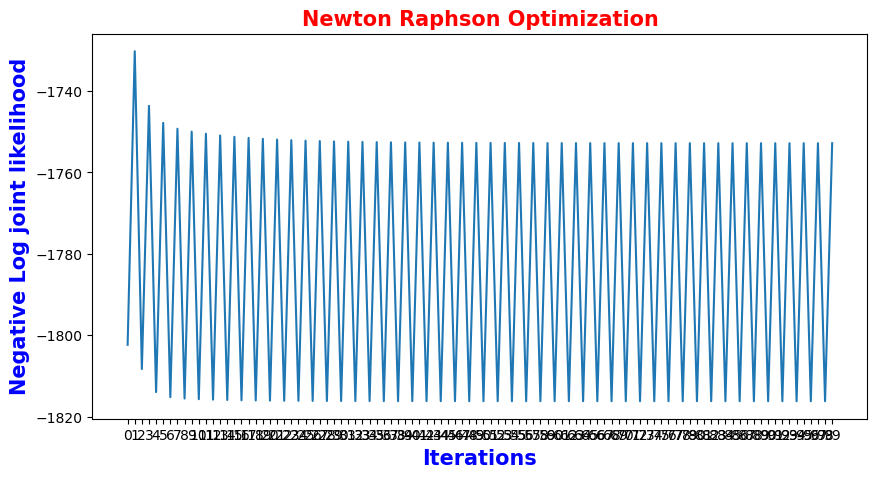

In [250]:
plt.figure(figsize=(10,5))
plt.plot(range(len(model.log_joint_likelihood_)), np.array(model.log_joint_likelihood_))
plt.xlabel("Iterations", weight="semibold", color='b', size=15)
plt.ylabel("Negative Log joint likelihood", weight="semibold", color='b', size=15)
plt.xticks(range(len(model.log_joint_likelihood_)))
plt.title("Newton Raphson Optimization", weight="semibold", color='r', size=15)
plt.show()